In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

import math
import pandas as pd
import numpy as np


# import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# device = torch.device("cuda" if torch.version.hip else "cpu")
# print(device)
df = pd.read_excel("forecast_data20242-025.xlsx", header=2)
df.head()

TrnYear  TrnMonth  Register  Invoice  SummaryLine  DetailLine InvoiceDate  \
0     2024         1         2    21165            1           1  2023-07-04   
1     2024         1         3    21166            1           1  2023-07-05   
2     2024         1         3    21166            1           2  2023-07-05   
3     2024         1         3    21166            1           3  2023-07-05   
4     2024         1         3    21166            1           4  2023-07-05   

  Branch Cust # Customer Name  ... GlYear GlPeriod  SalesOrder ContractPrcNum  \
0     LD   L001     L001 - SA  ...   2024        1       20044   202306-GENV1   
1     LD   E001     E001 - SA  ...   2024        1       19998   202306-GENV1   
2     LD   E001     E001 - SA  ...   2024        1       19998   202306-GENV1   
3     LD   E001     E001 - SA  ...   2024        1       19998   202306-GENV1   
4     LD   E001     E001 - SA  ...   2024        1       19998   202306-GENV1   

  LineInvoiceDisc  PostCurrency  SalesOrderLine  StockUom   Colour  \
0             0.0             R               1        EA  Magenta   
1             0.0             R               1        EA     Cyan   
2             0.0             R               2        EA  Magenta   
3             0.0             R               3        EA   Yellow   
4             0.0             R               4        EA    Clear   

      Container  
0     Bottle 5L  
1  Pouch 2000ml  
2  Pouch 2000ml  
3  Pouch 2000ml  
4     Bottle 2L  

[5 rows x 35 columns]

In [3]:
print(df.shape)

(21565, 35)


### DATA preprocessing

In [4]:
#easier column classification
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.rename( columns= {"InvoiceDate": "date" ,
                          "Customer Name": "cust_id",
                          "QtyInvoiced": "qty",
                          "Unit": "price",
                          "SKU": "item",
                          "Region2": "region",
                          "Colour": "color",
                          "Container": "container",
                          "NetSalesValue": "netsales",
                          "PostCurrency": "currency",
                         
                         })

#ensure ints and categories are category
df['item'] = df['item'].astype("category")
df['region'] = df['region'].astype("category")
df['area'] = df['Area'].astype("category")
df['cust_id'] = df['cust_id'].astype("category")
df['cust_code'] = df['Cust #'].astype("category")
df["category"] = (df['color'] + "_" + df["container"]).astype("category")
df['color'] = df['color'].astype("category")
df['container'] = df['container'].astype("category")
df['currency'] = df['currency'].astype("category")
df = df.sort_values(by=["cust_id", "item", "date"])



In [5]:
df.columns

Index(['TrnYear', 'TrnMonth', 'Register', 'Invoice', 'SummaryLine',
       'DetailLine', 'date', 'Branch', 'Cust #', 'cust_id', 'Area', 'region',
       'item', 'SKU Description', 'Warehouse', 'qty', 'Mass', 'Volume',
       'price', 'netsales', 'TaxValue', 'DiscValue', 'LineType', 'PriceCode',
       'DocumentType', 'GlYear', 'GlPeriod', 'SalesOrder', 'ContractPrcNum',
       'LineInvoiceDisc', 'currency', 'SalesOrderLine', 'StockUom', 'color',
       'container', 'area', 'cust_code', 'category'],
      dtype='object')

In [6]:
df = df.drop(['TrnYear', 'TrnMonth', 'Register', 'Invoice', 'SummaryLine',
       'DetailLine',  'Branch', 'Cust #', 
     'SKU Description', 'Warehouse', 'Mass',
       'Volume',  'TaxValue', 'DiscValue', 'LineType',
       'PriceCode', 'DocumentType', 'GlYear', 'GlPeriod', 'SalesOrder',
       'ContractPrcNum', 'LineInvoiceDisc', 'SalesOrderLine',
       'StockUom'], axis=1)

In [7]:

print(df["category"].nunique())
print(df["item"].nunique())

133
1177


In [8]:
df.dtypes

date         datetime64[ns]
cust_id            category
Area                 object
region             category
item               category
qty                   int64
price                 int64
netsales              int64
currency           category
color              category
container          category
area               category
cust_code          category
category           category
dtype: object

In [9]:
df.head()

date    cust_id Area     region     item  qty  price  netsales  \
8338 2024-04-10  A001 - AP   AP  AUSTRALIA  4750522   12    500      6000   
8339 2024-04-10  A001 - AP   AP  AUSTRALIA  4750523    6    500      3000   
8340 2024-04-10  A001 - AP   AP  AUSTRALIA  4750524   12    500      6000   
8341 2024-04-10  A001 - AP   AP  AUSTRALIA  4750525    6    500      3000   
8342 2024-04-10  A001 - AP   AP  AUSTRALIA  4750541   30    600     18000   

     currency    color  container area cust_code           category  
8338      USD     Cyan  Bottle 1L   AP      A001     Cyan_Bottle 1L  
8339      USD  Magenta  Bottle 1L   AP      A001  Magenta_Bottle 1L  
8340      USD   Yellow  Bottle 1L   AP      A001   Yellow_Bottle 1L  
8341      USD    Black  Bottle 1L   AP      A001    Black_Bottle 1L  
8342      USD    White  Bottle 1L   AP      A001    White_Bottle 1L

In [10]:
#no weekend data
print((df.date.dt.dayofweek >= 5).describe())

#Unique clients, regions, product
print("Unique Clients:", df.cust_id.nunique())
print("Unique regions:", df.region.nunique())
print("Unique products:", df.category.nunique())

count     21565
unique        1
top       False
freq      21565
Name: date, dtype: object
Unique Clients: 75
Unique regions: 46
Unique products: 133


In [11]:

df['dayofweek'] = df['date'].dt.dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
df['month'] = df['date'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear']/365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear']/365)
df['day'] = df['date'].dt.day
df['day_sin'] = np.sin(2 * np.pi * df['day']/30)
df['day_cos'] = np.cos(2 * np.pi * df['day']/30)
df['year'] = df['date'].dt.year
df["client_item_id"] = (df["cust_id"].astype(str) + "_" + df["item"].astype(str)).astype('category')
df['quarter'] = df.date.dt.quarter
df['quarter_sin'] = np.sin(2 * np.pi * df['quarter']/4)
df['quarter_cos'] = np.cos(2 * np.pi * df['quarter']/4)

df['is_year_start'] = df.date.dt.is_year_start
df['is_year_end'] = df.date.dt.is_year_end
df['is_month_start'] = df.date.dt.is_month_start
df['is_month_end'] = df.date.dt.is_month_end
df["qty_sold"] = np.where(df["qty"] >= 0, df["qty"], 0)
df["qty_soldR2"] = df["qty_sold"] ** 2
df["qty_returned"] = np.where(df["qty"] < 0, -df["qty"], 0)
df["qty_log"] = np.log1p(df["qty"])
df["qty_sold_log"] = np.log1p(df["qty_sold"])
df["qty_soldR2_log"] = np.log1p(df["qty_soldR2"])



/mnt/generalNVME/projects/AI/ITMDA-Assignment_Predictive-Inventory-System/forecast/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/generalNVME/projects/AI/ITMDA-Assignment_Predictive-Inventory-System/forecast/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
daily = (
    df.groupby(['date']).agg(
        {
            "qty_sold": "sum",
        })
      
)
client_total_qty = (df.groupby(["cust_id"]).agg({
    "qty_sold": "sum",
    }))
region_qty = df.groupby(["region"]).agg({
    "qty_sold": "sum",
    }) 
daily["rolling_mean"] = daily["qty_sold"].rolling(window=7).mean()

/tmp/ipykernel_6449/2596667286.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  client_total_qty = (df.groupby(["cust_id"]).agg({
/tmp/ipykernel_6449/2596667286.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_qty = df.groupby(["region"]).agg({


In [13]:
client_total_qty.head()

qty_sold
cust_id            
A001 - AP        66
A001 - EU         7
A001 - MA        52
A001 - OE        54
A001 - SA     36453

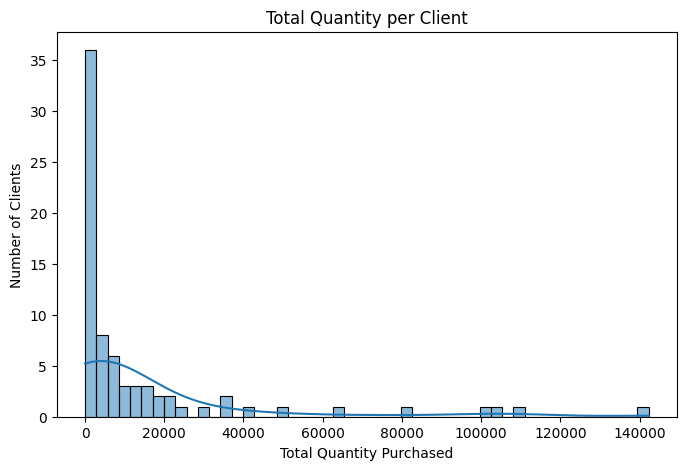

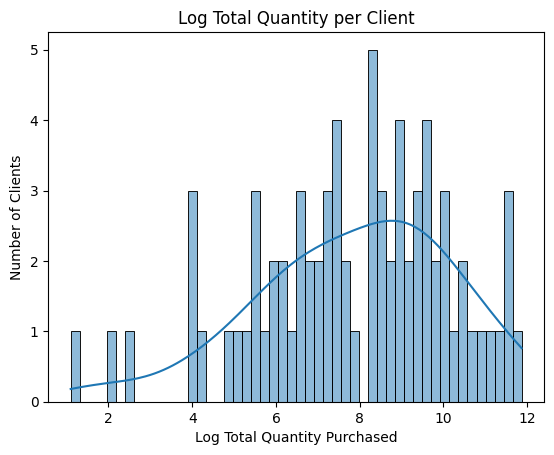

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(client_total_qty.qty_sold, bins=50, kde=True, edgecolor="black")
plt.title("Total Quantity per Client")
plt.xlabel("Total Quantity Purchased")
plt.ylabel("Number of Clients")
plt.show()
sns.histplot(np.log1p(client_total_qty.qty_sold), bins=50, kde=True, edgecolor="black")
plt.title("Log Total Quantity per Client")
plt.xlabel("Log Total Quantity Purchased")
plt.ylabel("Number of Clients")
plt.show()


In [15]:
daily.describe()

qty_sold  rolling_mean
count    470.000000    464.000000
mean    2375.051064   2376.834667
std     2868.540420   1009.960434
min        0.000000    331.571429
25%      436.500000   1642.357143
50%     1220.000000   2272.928571
75%     3414.750000   3156.892857
max    20287.000000   5509.428571

In [16]:
client_total_qty.describe()

qty_sold
count      75.000000
mean    14883.653333
std     28259.110491
min         2.000000
25%       603.500000
50%      3794.000000
75%     13880.000000
max    142315.000000

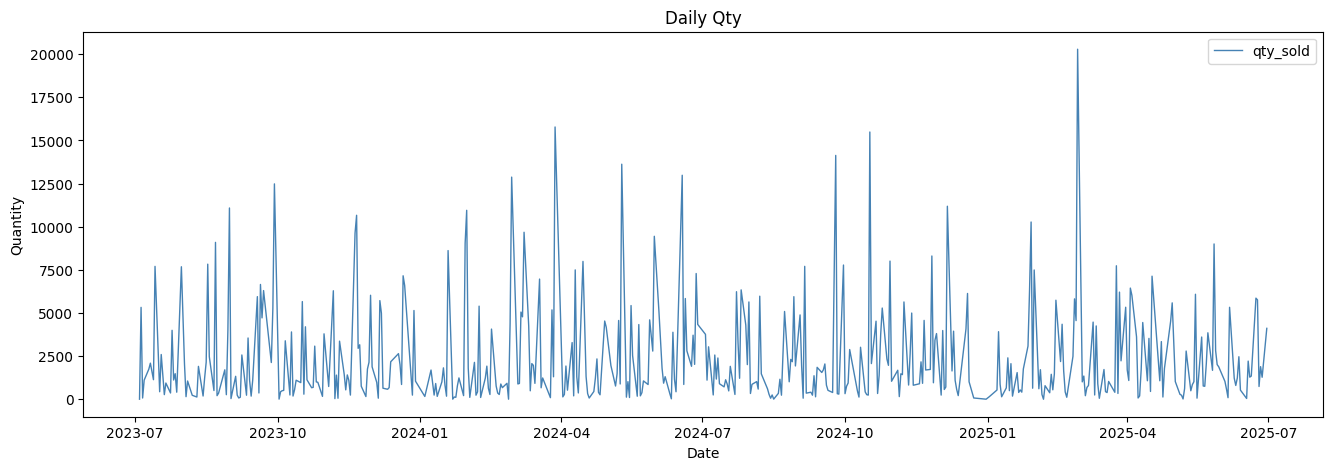

In [17]:
plt.figure(figsize=(16,5))
plt.plot(daily.qty_sold,
         color='steelblue', linewidth=1,
         label="qty_sold"
    )
plt.title("Daily Qty")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()

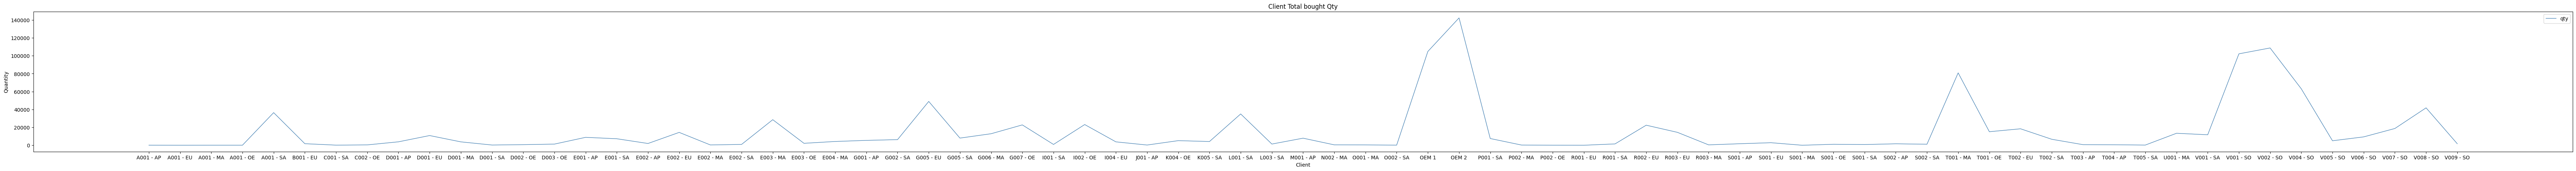

In [18]:
plt.figure(figsize=(90,5))
plt.plot(client_total_qty.qty_sold,
         color='steelblue', linewidth=1,
         label="qty"
    )
plt.title("Client Total bought Qty")
plt.xlabel("Client")
plt.ylabel("Quantity")
plt.legend()
plt.show()

In [19]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import acf, kpss, adfuller
# from statsmodels.graphics.tsaplots import plot_acf
# stat, p_value, lags, crit = kpss(daily.qty_sold, regression='c', nlags="auto")

# def analyze_time_series(item, ts, freq='D', seasonal_period=None, plot=True):
#     """
#     Analyze a time series for stationarity and seasonality.

#     Parameters:
#         ts (pd.Series): Time series with datetime index.
#         freq (str): Frequency of the series ('D', 'M', etc.)
#         seasonal_period (int): Number of observations per seasonal cycle.
#         plot (bool): Whether to plot ACF and decomposition.

#     Returns:
#         dict: Results of ADF and KPSS tests.
#     """
#     results = {}
    
#     # Ensure numeric
#     ts = ts.astype(float)
    
#     # --- ADF test ---
#     adf_result = adfuller(ts)
#     results['ADF Statistic'] = adf_result[0]
#     results['ADF p-value'] = adf_result[1]
    
#     # --- KPSS test ---
#     try:
#         kpss_result = kpss(ts, regression='c', nlags="auto")
#         results['KPSS Statistic'] = kpss_result[0]
#         results['KPSS p-value'] = kpss_result[1]
#     except:
#         results['KPSS Statistic'] = np.nan
#         results['KPSS p-value'] = np.nan
    
#     # Interpretation
#     results['ADF stationary'] = adf_result[1] <= 0.05
#     results['KPSS stationary'] = kpss_result[1] > 0.05 if 'KPSS p-value' in results else np.nan
    
#     # --- Optional plots ---  
#     print (f"Stats for: {item}")
#     print("ADF p-value:", adf_result[1], "| Stationary:" , results['ADF stationary'])
#     print("KPSS p-value:", results.get('KPSS p-value'), "| Stationary:" , results.get('KPSS stationary'))
#     if plot:

        
#         # Plot ACF
#         plt.figure(figsize=(10,4))
#         plot_acf(ts, lags=30)
#         plt.title(f"Autocorrelation (ACF) [{item}]")
#         plt.show()
        
#         # Decomposition
#         if seasonal_period:
#             decomp = seasonal_decompose(ts, model='additive', period=seasonal_period)
#             decomp.plot()
#             plt.show()
    
#     return results

In [20]:
# deseasonal = daily.qty_sold - decomp.seasonal
# plt.figure(figsize=(15,5))
# plt.plot(daily.date, deseasonal,
#          color='steelblue', linewidth=1
#     )
# plt.title("Daily Qty Sold (Deseasonal)")
# plt.xlabel("Date")
# plt.ylabel("Quantity")
# plt.show()
# analyze_time_series("All", daily.qty_sold, seasonal_period=7, plot=True)

In [21]:
daily_by_customer = df.groupby(['cust_id', 'date'], as_index=False)['qty'].sum()
daily_by_item = df.groupby(['category', 'date'], as_index=False)['qty'].sum()

/tmp/ipykernel_6449/2249288185.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_by_customer = df.groupby(['cust_id', 'date'], as_index=False)['qty'].sum()
/tmp/ipykernel_6449/2249288185.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_by_item = df.groupby(['category', 'date'], as_index=False)['qty'].sum()


In [22]:
daily_by_item

category       date  qty
0            _Bottle 0.5L 2023-07-04    0
1            _Bottle 0.5L 2023-07-05    0
2            _Bottle 0.5L 2023-07-06    0
3            _Bottle 0.5L 2023-07-07    0
4            _Bottle 0.5L 2023-07-10    0
...                   ...        ...  ...
62505  Yellow_Pouch 500ml 2025-06-24    0
62506  Yellow_Pouch 500ml 2025-06-25    0
62507  Yellow_Pouch 500ml 2025-06-26    0
62508  Yellow_Pouch 500ml 2025-06-27    0
62509  Yellow_Pouch 500ml 2025-06-30    0

[62510 rows x 3 columns]

In [23]:
"""
mostly meaningless but just wanted some pattern insight
"""
# uniq_items = daily_by_item.color_container.unique()
# for i in uniq_items:
#     print("-"*100)
#     iframe = daily_by_item[daily_by_item.color_container == i]
#     print(iframe.qty)
#     plt.title(f"{i}")
#     plt.plot(iframe.date, iframe.qty)
#     plt.show()
#     r = analyze_time_series(i, iframe.qty, seasonal_period=7, plot=False)
#     print(r)

'\nmostly meaningless but just wanted some pattern insight\n'

In [24]:
# g = sns.FacetGrid(daily_by_customer, col="cust_id", col_wrap=4, height=3, sharey=False)
# g.map_dataframe(sns.scatterplot, x="date", y="qty", s=20)
# g.map_dataframe(sns.lineplot, x="date", y="qty")
# g.set_titles("Customer {col_name}")
# plt.show()


In [25]:
# Number of unique customers, specific items, actual item
df[["cust_id" ,"item", "category"]].nunique()

cust_id       75
item        1177
category     133
dtype: int64

In [26]:
def split_train_test(df, split_date):
    train = df[df['date'] < split_date].copy()
    test = df[df['date'] >= split_date].copy()
    return (train, test)

def target_feature_split(df, features, target):
    X, y = df[features], df[target]
    return (X, y)
    


Validation RMSE: 118.29715


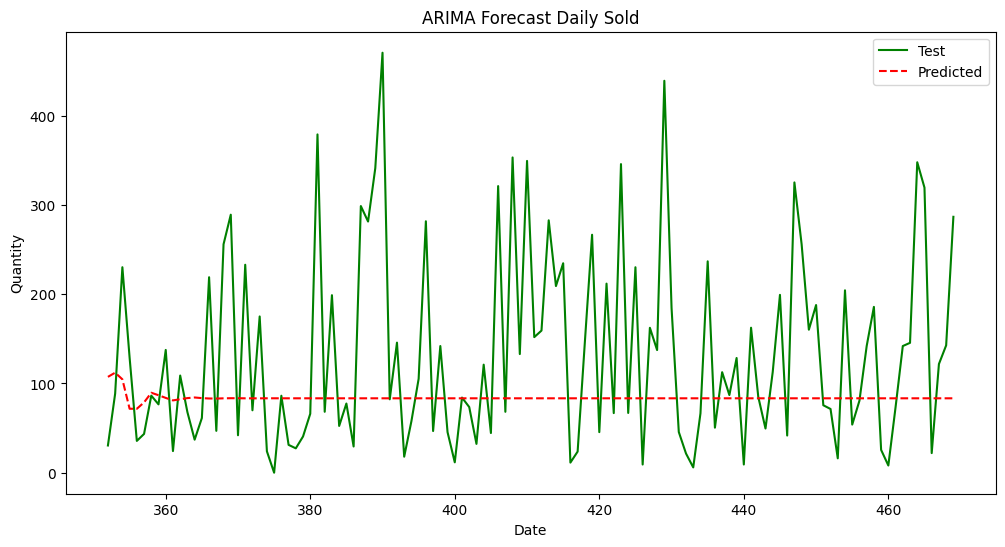

In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error

dailySold = (
    df.groupby(['date'])['qty_sold_log']
      .sum()
      .reset_index()
)
split_date = "2025-01-01"
trg = "qty_sold_log"
atr, ats = split_train_test(dailySold,split_date)
atr, ats = atr[trg], ats[trg]

model = ARIMA(atr, order=(5,1,0))  # (p,d,q)
model_fit = model.fit()

# Forecast for test period

y_pred = model_fit.forecast(steps=len(ats))
y_true = ats.clip(0)
y_pred_clip = y_pred.clip(0)
rmse = root_mean_squared_error(ats, y_pred)
rmsle = root_mean_squared_log_error(y_true, y_pred_clip)

print(f"Validation RMSE: {rmse:.5f}")
plt.figure(figsize=(12,6))
plt.plot(ats.index, ats, label='Test', color='green')
plt.plot(ats.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('ARIMA Forecast Daily Sold')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

### BASELINE LightBGM

In [126]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Define split date
split_date = '2025-03-01'
target = "qty_sold"

basic_feats = ["cust_id","day","item", "price", "month", "year", "currency", "region", "dayofweek", "dayofyear"]
train , test = split_train_test(df, split_date)
X_train, y_train = target_feature_split(train, basic_feats, target)
X_val, y_val = target_feature_split(test, basic_feats, target)

cat_feats = ['cust_id', 'region', 'currency']
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feats)
lgb_test = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=cat_feats)
params_tweedie = {
    'objective': 'poisson',
    # 'tweedie_variance_power': 1.3,  
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}
model = lgb.train(
    params_tweedie,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train','valid'],
    num_boost_round=1000,
)


# Evaluate (RMSLE)
y_val_pred = model.predict(X_val)
# rmsle = root_mean_squared_log_error(y_val, val_pred)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")
print(f"Val R2: {r2_score(y_val, y_val_pred):.5f}")


y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.5f}")
print(f"Training MAE: {mae:.5f}")
print(f"Training R2: {r2_score(y_train, y_train_pred):.5f}")


Validation RMSE: 66.42326
Validation MAE: 29.57784
Val R2: 0.45092
Training RMSE: 39.59520
Training MAE: 18.69269
Training R2: 0.87417


In [29]:
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor


class HyperPSOTuning:

    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        
    def lgb_obj_function(self,params):
        losses = []
        for p in params:
            num_leaves = int(p[0])
            max_depth = int(p[1])
            learning_rate = p[2]
            n_estimators = int(p[3])
            feature_fraction = p[4]
            bagging_fraction = p[5]
            bagging_freq = int(p[6])
            lambda_l1 = p[7]
            lambda_l2 = p[8]
            min_data_in_leaf = int(p[9])
            tweedie_variance_power = int(p[12])
    
            model = LGBMRegressor(
                objective="regression",
                # tweedie_variance_power= tweedie_variance_power,
                metric="rmse",
                boosting_type="gbdt",
                n_estimators=n_estimators,  
                num_leaves=num_leaves,
                max_depth=max_depth,
                learning_rate=learning_rate,
                feature_fraction=feature_fraction,
                bagging_fraction=bagging_fraction,
                bagging_freq=bagging_freq,
                lambda_l1=lambda_l1,
                lambda_l2=lambda_l2,
                min_data_in_leaf=min_data_in_leaf,
                verbose=-1
            )
            model.fit(self.X_train, self.y_train)
            preds = model.predict(self.X_val)
            rmse = root_mean_squared_error(self.y_val, preds)
            losses.append(rmse)
    
        return np.array(losses)

    def tune(self,lb, ub):
        options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

        optimizer = GlobalBestPSO(
            n_particles=10,   
            dimensions=len(lb),     
            options=options,
            bounds=(lb, ub)
        )


        best_cost, best_pos = optimizer.optimize(self.lgb_obj_function, iters=20)
        return best_cost, best_pos







In [30]:
# --- Lower and Upper Bounds (lb, ub) for PSO ---
# Each position in the array corresponds to a hyperparameter index.

lb = [
    16,     # [0] num_leaves — controls model complexity (fewer = simpler)
    2,      # [1] max_depth — tree depth (-1 means unlimited)
    0.001,  # [2] learning_rate — smaller = slower but more accurate training
    100,    # [3] n_estimators — number of boosting rounds (trees)
    0.3,    # [4] feature_fraction — fraction of features per iteration
    0.3,    # [5] bagging_fraction — fraction of data per iteration
    1,      # [6] bagging_freq — how often to perform bagging
    0.0,    # [7] lambda_l1 — L1 regularization term
    0.0,    # [8] lambda_l2 — L2 regularization term
    5,      # [9] min_data_in_leaf — min samples per leaf (controls overfitting)
    50,     # [10] max_bin — number of bins for discretizing continuous features
    0.0,     # [11] min_gain_to_split — min gain required to make a split
    1     # [12] tweedie_variance_power
]

ub = [
    512,    # [0] num_leaves — higher = more complex model, risk of overfitting
    16,     # [1] max_depth — deeper trees = more complex model
    0.3,    # [2] learning_rate — higher = faster training, more risk of overfit
    2000,   # [3] n_estimators — more boosting rounds for low learning rates
    1.0,    # [4] feature_fraction — use all features if 1.0
    1.0,    # [5] bagging_fraction — use full dataset if 1.0
    10,     # [6] bagging_freq — bagging every N iterations
    1.0,    # [7] lambda_l1 — stronger L1 = more feature sparsity
    5.0,    # [8] lambda_l2 — stronger L2 = smoother weights
    500,    # [9] min_data_in_leaf — larger = smoother model (less overfit)
    255,    # [10] max_bin — finer binning for continuous features
    5.0,     # [11] min_gain_to_split — higher = only large gains allowed
    2     # [12] tweedie_variance_power
]


# tuner = HyperPSOTuning(X_train, y_train, X_val, y_val)
# best_cost, best_pos = tuner.tune(lb, ub)

# print("Best RMSE:", best_cost)
# print("Best hyperparameters:", best_pos)

In [63]:
import matplotlib.pyplot as plt

# Example variables
# y_train: training target values
# y_val: validation target values
# y_pred: model predictions on validation set
def plot_target(y_val, y_pred, figsize = (12,6)):
    plt.figure(figsize= figsize)
    
    y_val = np.array(y_val)
    y_pred = np.array(y_pred)
    
    # Plot validation target
    plt.plot(np.arange(len(y_val)), y_val, label="y_val", color="green")
    
    # Plot predictions
    plt.plot(np.arange(len(y_pred)), y_pred, label="y_pred", color="red", linestyle="--")
    
    plt.xlabel("Time / Index")
    plt.ylabel("Quantity")
    plt.title("Validation vs Predictions")
    plt.legend()
    plt.show()


In [32]:
y_pred.describe()

count    118.000000
mean      83.831103
std        4.319969
min       71.629506
25%       83.376631
50%       83.376631
75%       83.376631
max      112.086303
Name: predicted_mean, dtype: float64

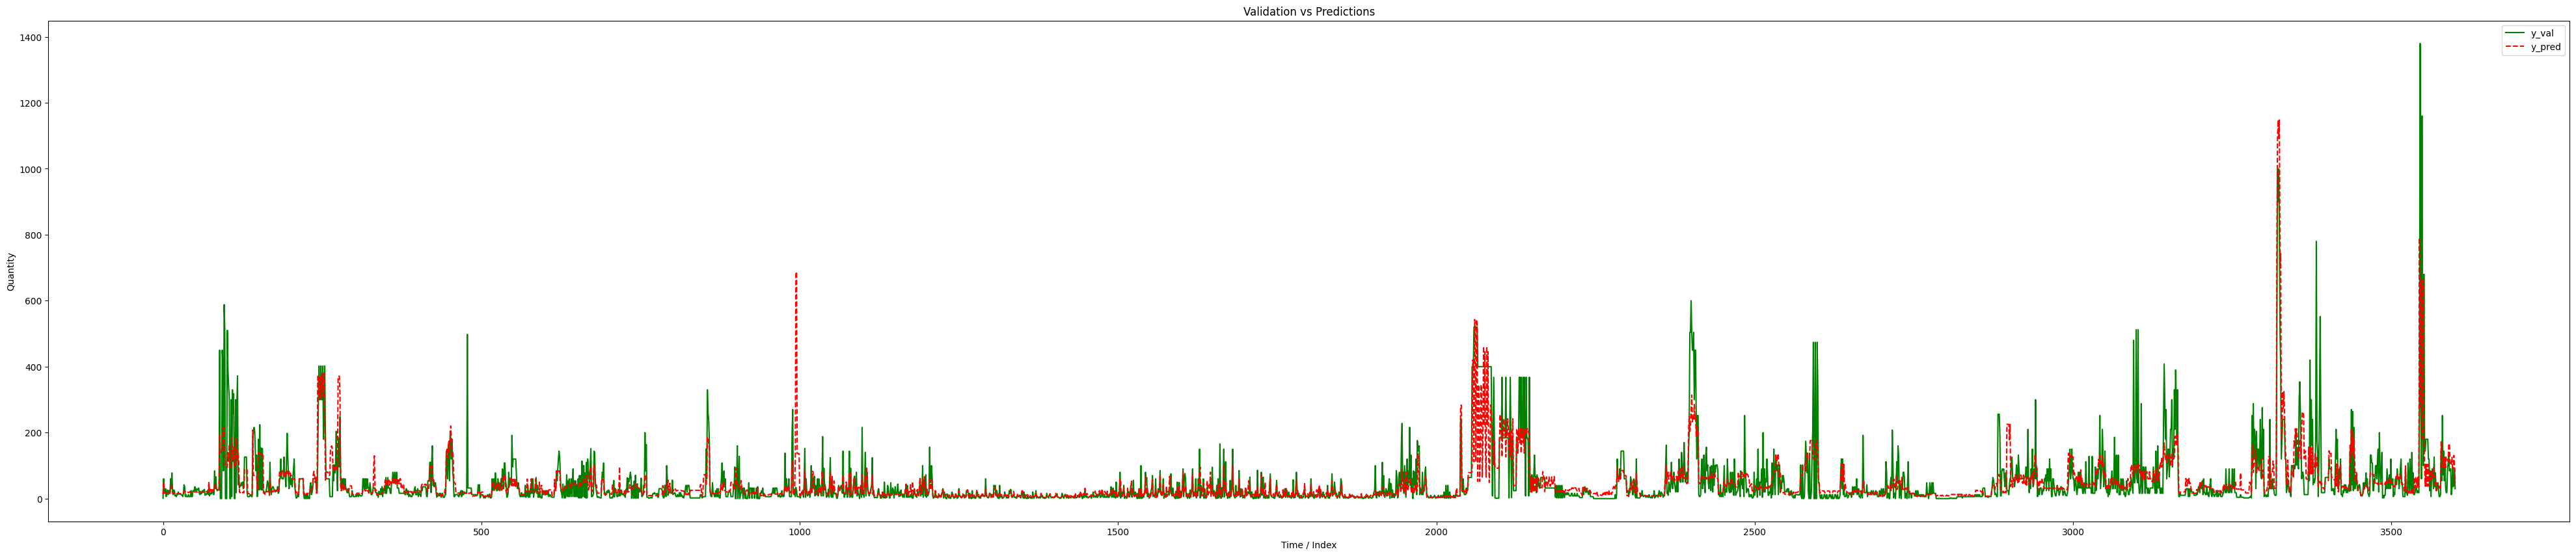

In [130]:
plot_target(y_val, y_val_pred, figsize=(50,10))

In [34]:
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np


def train_model(train, val, cat_feats, params):
    model = LGBMRegressor(
    **params
    )

    model.fit(
    train["X"], train["y"],
    eval_set=[(val["X"], val["y"])],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[]
    )

    return model

def evaluate_model(model, X_val, y_val):
    val_pred = model.predict(X_val)
    # rmsle = root_mean_squared_log_error(y_val, val_pred)
    rmse = root_mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    # print(f"Validation RMSLE: {rmsle:.5f}")
    print(f"Validation RMSE: {rmse:.5f}")
    print(f"Validation MAE: {mae:.5f}")
    return val_pred

In [35]:
df.columns

Index(['date', 'cust_id', 'Area', 'region', 'item', 'qty', 'price', 'netsales',
       'currency', 'color', 'container', 'area', 'cust_code', 'category',
       'dayofweek', 'dayofweek_sin', 'dayofweek_cos', 'month', 'month_sin',
       'month_cos', 'dayofyear', 'dayofyear_sin', 'dayofyear_cos', 'day',
       'day_sin', 'day_cos', 'year', 'client_item_id', 'quarter',
       'quarter_sin', 'quarter_cos', 'is_year_start', 'is_year_end',
       'is_month_start', 'is_month_end', 'qty_sold', 'qty_soldR2',
       'qty_returned', 'qty_log', 'qty_sold_log', 'qty_soldR2_log'],
      dtype='object')

### More Feature engineering

In [154]:
#create lags and rolling
target = "qty_sold_log"
sold_df = df[df["qty_returned"] == 0]
sold_df = sold_df.sort_values(["cust_id", "item", "date"])
lags = [1, 7]
cust_item = sold_df.groupby(["cust_id", "item"])
for lag_i in lags:
    sold_df[f"{target}_lag{lag_i}"] =  cust_item[target].shift(lag_i).fillna(0)
lag_feats = [ f"{target}_lag{i}" for i in lags]


for i in [3, 7]:
    sold_df[f"rolling_mean_{i}"] = (
        cust_item[target]
            .shift(1)
            .rolling(i)
            .mean()
    )
    lag_feats.append(f"rolling_mean_{i}")
    sold_df[f"rolling_std_{i}"] = (
        cust_item[target]
            .shift(1)  
            .rolling(i)
            .std()
    )
    
    lag_feats.append(f"rolling_std_{i}")

sold_df["days_since_client_purchase"] =  df.groupby("cust_id")["date"].diff().dt.days
lag_feats.append("days_since_client_purchase")
sold_df["days_since_client_item_purchase"] =  df.groupby(["cust_id", "item"])["date"].diff().dt.days
lag_feats.append("days_since_client_item_purchase")

/tmp/ipykernel_6449/3371781608.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cust_item = sold_df.groupby(["cust_id", "item"])
/tmp/ipykernel_6449/3371781608.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sold_df["days_since_client_purchase"] =  df.groupby("cust_id")["date"].diff().dt.days
/tmp/ipykernel_6449/3371781608.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sold_df["days_since_client_item_purcha

In [155]:

# df.to_csv("full_df.csv", index=False)

In [156]:
lag_feats

['qty_sold_log_lag1',
 'qty_sold_log_lag7',
 'rolling_mean_3',
 'rolling_std_3',
 'rolling_mean_7',
 'rolling_std_7',
 'days_since_client_purchase',
 'days_since_client_item_purchase']

In [157]:
# df["series_id"] = (df["cust_id"].astype(str) + "_" + df["item"].astype(str)).astype("category")
cat_feats = ["cust_id", "cust_code",  "item", "currency",  "region", "category", "price"]
basic_feats = ["cust_code","price", "cust_id",  "item", "currency",  "region", "category"]
time_feats = ["day_sin", "day_cos", "month","dayofweek_cos","dayofweek_sin","dayofyear_sin", "dayofyear_cos", "quarter_sin", "quarter_cos"]

In [158]:
# df['qty_returned'].value_counts()

In [159]:
# df["is_return"] = (df["qty_returned"] > 0).astype(int)
# basic_feats.append("is_return")

In [160]:
sold_df.sort_values(["date"], inplace=True)
split_date = "2025-01-01"
train , test = split_train_test(sold_df, split_date)

train.sort_values(["date"], inplace=True)
test.sort_values(["date"], inplace=True)

### Client Behaviour feature

In [161]:
# TRAIN
train_freq = train.groupby('cust_id')[target].sum() / train.groupby('cust_id')['date'].nunique()
train['client_rel_freq'] = train['cust_id'].map(train_freq)

# VALIDATION / TEST
test['client_rel_freq'] = test['cust_id'].map(train_freq)  # use mapping from train only
test['client_rel_freq'].fillna(0, inplace=True)


behaviour_feats = ['client_rel_freq']

/tmp/ipykernel_6449/2267526625.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_freq = train.groupby('cust_id')[target].sum() / train.groupby('cust_id')['date'].nunique()
/tmp/ipykernel_6449/2267526625.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['client_rel_freq'].fillna(0, inplace=True)


In [162]:
# train["item_qty_avg"] = train.groupby("item")[target].transform("mean").astype(np.float32)
# train["cust_qty_avg"] = train.groupby("cust_id")[target].transform("mean").astype(np.float32)
# train["cust_item_qty_avg"] = train.groupby(["cust_id", "item"])[target].transform("mean").astype(np.float32)
# # Create mapping from category -> mean
# item_mean_map = train.groupby("item")[target].mean()
# cust_mean_map = train.groupby("cust_id")[target].mean()
# cust_item_mean_map = train.groupby(["cust_id","item"])[target].mean()
# test["item_qty_avg"] = test["item"].map(item_mean_map)
# test["cust_qty_avg"] = test["cust_id"].map(cust_mean_map)
# test["cust_item_qty_avg"] = test.set_index(["cust_id","item"]).index.map(cust_item_mean_map)
feats = basic_feats + time_feats + lag_feats + behaviour_feats # + ['item_qty_avg', 'cust_qty_avg', 'cust_item_qty_avg'] 

In [163]:
train["price"] = np.log1p(train["price"])
test["price"] = np.log1p(test["price"])

In [164]:
train

date    cust_id Area        region     item  qty     price  \
0     2023-07-04  L001 - SA   SA  SOUTH AFRICA  4750828    2  7.496097   
27    2023-07-05  V002 - SO   SO        BRAZIL  4750006   20  6.216606   
47    2023-07-05  V007 - SO   SO        BRAZIL  4750590   10  7.090910   
57    2023-07-05  V007 - SO   SO        BRAZIL  4750663   30  5.993961   
26    2023-07-05  V002 - SO   SO        BRAZIL  4750005   90  5.303305   
...          ...        ...  ...           ...      ...  ...       ...   
16277 2024-12-20  I002 - OE   OE   SWITZERLAND  4750453  122  7.438972   
16296 2024-12-20  I002 - OE   OE   SWITZERLAND  4750858   10  8.268988   
16300 2024-12-23  K005 - SA   SA  SOUTH AFRICA  4751119   36  5.993961   
16299 2024-12-23  K005 - SA   SA  SOUTH AFRICA  4751120   36  5.993961   
16301 2024-12-31  E001 - AP   AP      Malaysia  4750060    2  6.552508   

       netsales currency        color  ... qty_soldR2_log qty_sold_log_lag1  \
0          3600        R      Magenta  ...       1.609438          0.000000   
27        10000      USD        Clear  ...       5.993961          0.000000   
47        12000      USD        Black  ...       4.615121          0.000000   
57        12000      USD        Black  ...       6.803505          0.000000   
26        18000      USD        Clear  ...       8.999743          0.000000   
...         ...      ...          ...  ...            ...               ...   
16277    207400      EUR        Clear  ...       9.608109          5.017280   
16296     39000      EUR         Cyan  ...       4.615121          1.609438   
16300     14400        R    Fluo Pink  ...       7.167809          0.000000   
16299     14400        R  Fluo Yellow  ...       7.167809          0.000000   
16301      1400      USD      Magenta  ...       1.609438          3.713572   

      qty_sold_log_lag7 rolling_mean_3  rolling_std_3  rolling_mean_7  \
0              0.000000            NaN            NaN             NaN   
27             0.000000            NaN            NaN             NaN   
47             0.000000            NaN            NaN             NaN   
57             0.000000            NaN            NaN             NaN   
26             0.000000            NaN            NaN             NaN   
...                 ...            ...            ...             ...   
16277          5.198497       4.943450       0.127877        4.940342   
16296          0.000000       1.805367       0.339359             NaN   
16300          0.000000            NaN            NaN             NaN   
16299          0.000000            NaN            NaN             NaN   
16301          3.610918       3.124351       1.020560        3.423513   

       rolling_std_7  days_since_client_purchase  \
0                NaN                      -132.0   
27               NaN                      -198.0   
47               NaN                      -688.0   
57               NaN                      -688.0   
26               NaN                      -573.0   
...              ...                         ...   
16277       0.244855                        25.0   
16296            NaN                        92.0   
16300            NaN                       242.0   
16299            NaN                         0.0   
16301       0.668763                        67.0   

       days_since_client_item_purchase  client_rel_freq  
0                                  NaN        34.775892  
27                                 NaN        76.622273  
47                                 NaN        48.650059  
57                                 NaN        48.650059  
26                                 NaN        76.622273  
...                                ...              ...  
16277                             25.0        28.687672  
16296                             92.0        28.687672  
16300                              NaN        14.118157  
16299                              NaN        14.118157  
16301                             

In [165]:
train.columns

Index(['date', 'cust_id', 'Area', 'region', 'item', 'qty', 'price', 'netsales',
       'currency', 'color', 'container', 'area', 'cust_code', 'category',
       'dayofweek', 'dayofweek_sin', 'dayofweek_cos', 'month', 'month_sin',
       'month_cos', 'dayofyear', 'dayofyear_sin', 'dayofyear_cos', 'day',
       'day_sin', 'day_cos', 'year', 'client_item_id', 'quarter',
       'quarter_sin', 'quarter_cos', 'is_year_start', 'is_year_end',
       'is_month_start', 'is_month_end', 'qty_sold', 'qty_soldR2',
       'qty_returned', 'qty_log', 'qty_sold_log', 'qty_soldR2_log',
       'qty_sold_log_lag1', 'qty_sold_log_lag7', 'rolling_mean_3',
       'rolling_std_3', 'rolling_mean_7', 'rolling_std_7',
       'days_since_client_purchase', 'days_since_client_item_purchase',
       'client_rel_freq'],
      dtype='object')

In [166]:
feats

['cust_code',
 'price',
 'cust_id',
 'item',
 'currency',
 'region',
 'category',
 'day_sin',
 'day_cos',
 'month',
 'dayofweek_cos',
 'dayofweek_sin',
 'dayofyear_sin',
 'dayofyear_cos',
 'quarter_sin',
 'quarter_cos',
 'qty_sold_log_lag1',
 'qty_sold_log_lag7',
 'rolling_mean_3',
 'rolling_std_3',
 'rolling_mean_7',
 'rolling_std_7',
 'days_since_client_purchase',
 'days_since_client_item_purchase',
 'client_rel_freq']

In [167]:
# train.replace([np.inf, -np.inf], np.nan, inplace=True)
# test.replace([np.inf, -np.inf], np.nan, inplace=True)
# # Drop rows with any NaN (also removes original NaNs)
# train = train.dropna()
# test = test.dropna()

In [168]:
# df["category_mean_price"] = df.groupby(["cust_id", "color_container", "date"])["price"].transform("mean")
# train.head(100)

In [169]:
# feats.append('category_mean_price')

In [170]:
# train, test = train[train.qty_sold < 100], test[test.qty_sold < 100]
# feats.append("region")
# train , test = split_train_test(df, split_date)
X_train, y_train = target_feature_split(train, feats, target)
X_val, y_val = target_feature_split(test, feats, target)

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feats)
lgb_test = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=cat_feats)
params = {
    'objective': 'poisson',
    # 'tweedie_varianve_power': 1.3,
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train','valid'],
    num_boost_round=1000,
)
# params = {
#     "objective": "regression",
#     "n_estimators": 2000,
#     "metric": "rmse",
#     "learning_rate":0.001,
#     "max_depth": 8,
#     "num_leaves": 64
# }
# train_param = {
#     "X": X_train,
#     "y": y_train,
# }

# val_param = {
#     "X": X_val,
#     "y": y_val,
# }



y_val_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")
print(f"Val R2: {r2_score(y_val, y_val_pred):.5f}")
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.5f}")
print(f"Training MAE: {mae:.5f}")
print(f"Training R2: {r2_score(y_train, y_train_pred):.5f}")

# preds["pred_std"] = preds["q90"] - preds["q10"]
# print(preds[["q10", "q50", "q90", "pred_std"]].head())


Validation RMSE: 0.76870
Validation MAE: 0.58499
Val R2: 0.64657
Training RMSE: 0.61101
Training MAE: 0.46819
Training R2: 0.76018


In [171]:
X_train.shape


(15688, 25)

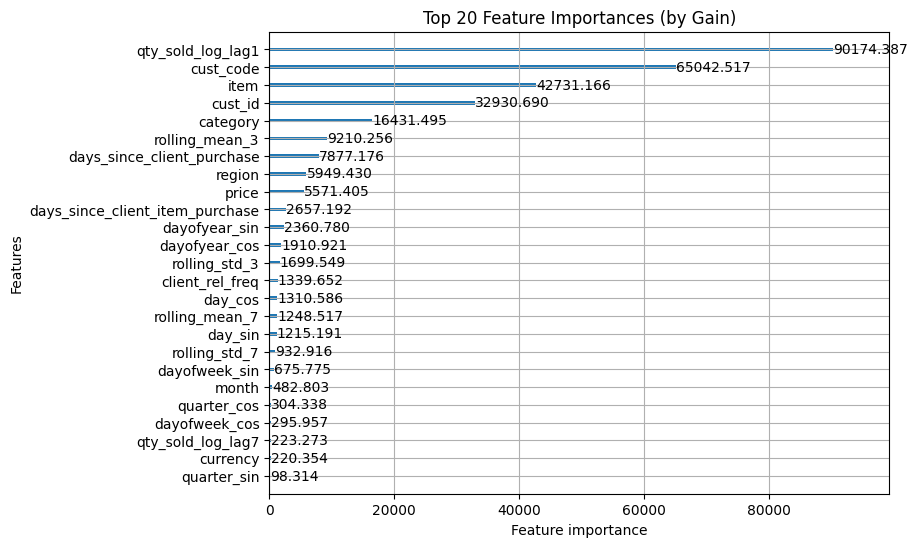

In [172]:

lgb.plot_importance(model, max_num_features=50, importance_type='gain', figsize=(8,6))
plt.title("Top 20 Feature Importances (by Gain)")
plt.show()

In [152]:
feats

['cust_code',
 'price',
 'cust_id',
 'item',
 'currency',
 'region',
 'category',
 'day_sin',
 'day_cos',
 'month',
 'dayofweek_cos',
 'dayofweek_sin',
 'dayofyear_sin',
 'dayofyear_cos',
 'quarter_sin',
 'quarter_cos',
 'qty_sold_lag1',
 'qty_sold_lag7',
 'rolling_mean_3',
 'rolling_std_3',
 'rolling_mean_7',
 'rolling_std_7',
 'days_since_client_purchase',
 'days_since_client_item_purchase',
 'client_rel_freq']

In [ ]:
# --- Lower and Upper Bounds (lb, ub) for PSO ---
# Each position in the array corresponds to a hyperparameter index.

lb = [
    16,     # [0] num_leaves — controls model complexity (fewer = simpler)
    2,      # [1] max_depth — tree depth (-1 means unlimited)
    0.001,  # [2] learning_rate — smaller = slower but more accurate training
    100,    # [3] n_estimators — number of boosting rounds (trees)
    0.3,    # [4] feature_fraction — fraction of features per iteration
    0.3,    # [5] bagging_fraction — fraction of data per iteration
    1,      # [6] bagging_freq — how often to perform bagging
    0.0,    # [7] lambda_l1 — L1 regularization term
    0.0,    # [8] lambda_l2 — L2 regularization term
    5,      # [9] min_data_in_leaf — min samples per leaf (controls overfitting)
    50,     # [10] max_bin — number of bins for discretizing continuous features
    0.0,     # [11] min_gain_to_split — min gain required to make a split
    1     # [12] tweedie_variance_power
]

ub = [
    512,    # [0] num_leaves — higher = more complex model, risk of overfitting
    16,     # [1] max_depth — deeper trees = more complex model
    0.3,    # [2] learning_rate — higher = faster training, more risk of overfit
    2000,   # [3] n_estimators — more boosting rounds for low learning rates
    1.0,    # [4] feature_fraction — use all features if 1.0
    1.0,    # [5] bagging_fraction — use full dataset if 1.0
    10,     # [6] bagging_freq — bagging every N iterations
    1.0,    # [7] lambda_l1 — stronger L1 = more feature sparsity
    5.0,    # [8] lambda_l2 — stronger L2 = smoother weights
    500,    # [9] min_data_in_leaf — larger = smoother model (less overfit)
    255,    # [10] max_bin — finer binning for continuous features
    5.0,     # [11] min_gain_to_split — higher = only large gains allowed
    2     # [12] tweedie_variance_power
]


tuner = HyperPSOTuning(X_train, y_train, X_val, y_val)
best_cost, best_pos = tuner.tune(lb, ub)

print("Best RMSE:", best_cost)
print("Best hyperparameters:", best_pos)

In [56]:
# train, test = train[train.qty_sold < 100], test[test.qty_sold < 100]
# feats.append("region")
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": int(best_pos[0]),
    "max_depth":  int(best_pos[1]),
    "learning_rate":  best_pos[2],
    "n_estimators": int(best_pos[3]),
    "feature_fraction": best_pos[4],
    "bagging_fraction": best_pos[5],
    "bagging_freq": int(best_pos[6]),
    "lambda_l1": best_pos[7],
    "lambda_l2": best_pos[8],
    "min_data_in_leaf": int(best_pos[9]),
    # "max_bin": int(best_pos[10]),
    "min_gain_to_split": best_pos[11],
    # 'tweedie_variance_power': best_pos[12], 
    "verbose": -1,
    "seed": 42
}


model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train','valid'],
    num_boost_round=1000,
)


y_val_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Validation RMSE: {rmse:.5f}")
print(f"Validation MAE: {mae:.5f}")
print(f"Validation MAPE: {mae:.5f}")
print(f"Val R2: {r2_score(y_val, y_val_pred):.5f}")
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse:.5f}")
print(f"Training MAE: {mae:.5f}")
print(f"Training R2: {r2_score(y_train, y_train_pred):.5f}")

# preds["pred_std"] = preds["q90"] - preds["q10"]
# print(preds[["q10", "q50", "q90", "pred_std"]].head())


NameError: name 'best_pos' is not defined

In [173]:
y_actual = y_val
y_pred = y_val_pred

In [174]:
resid_train = y_train - y_train_pred
resid_val = y_actual - y_pred


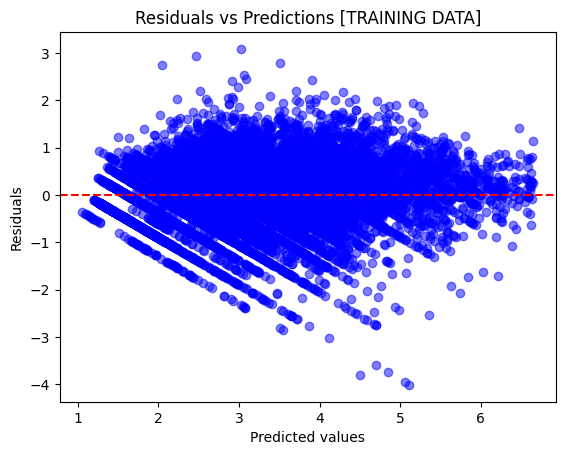

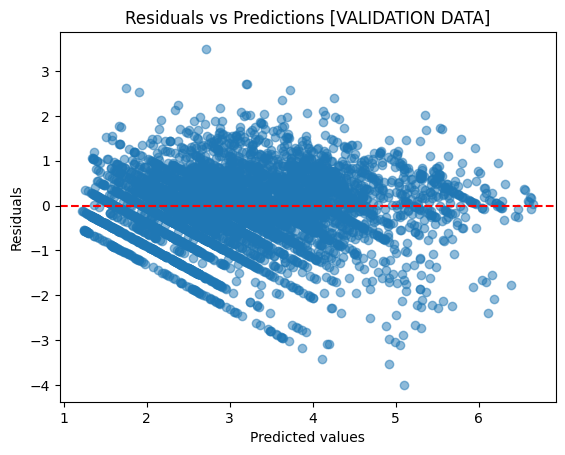

In [175]:
import matplotlib.pyplot as plt

plt.scatter(y_train_pred, resid_train, alpha=0.5, c='blue')
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [TRAINING DATA]")
plt.show()


plt.scatter(y_pred, resid_val, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions [VALIDATION DATA]")
plt.show()


In [176]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import numpy as np

print("TRAINING Heteroscedasticity TEST")
exog = sm.add_constant(y_train_pred)  
bp_test = het_breuschpagan(resid_train, exog)
print("Breusch–Pagan p-value:", bp_test[1])

white_test = het_white(resid_train, exog)
print("White test p-value:", white_test[1])
print("-"*10)
print("VALIDATION Heteroscedasticity TEST")
exog = sm.add_constant(y_val_pred)  
bp_test = het_breuschpagan(resid_val, exog)
print("Breusch–Pagan p-value:", bp_test[1])

white_test = het_white(resid_val, exog)
print("White test p-value:", white_test[1])

TRAINING Heteroscedasticity TEST
Breusch–Pagan p-value: 2.4721429172127157e-34
White test p-value: 3.388735390034837e-61
----------
VALIDATION Heteroscedasticity TEST
Breusch–Pagan p-value: 1.7727803389817435e-10
White test p-value: 2.103470400688902e-12


In [177]:
resid_val

16317   -0.862811
16316    0.134308
16304    0.003526
16307    0.125433
16305   -1.018057
           ...   
21501   -0.844365
21482    0.667028
21540   -0.236701
21481    0.557589
21510   -0.209804
Name: qty_sold_log, Length: 5077, dtype: float64

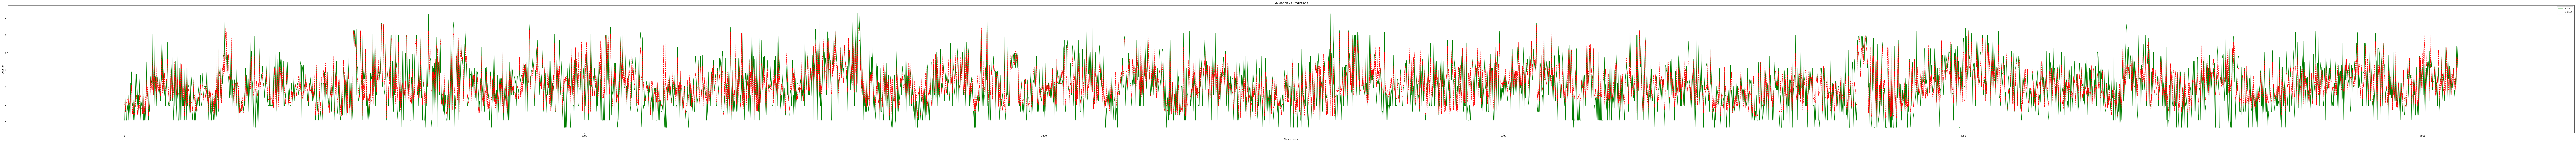

In [179]:
plot_target(y_val, y_val_pred, figsize= (200,10))

In [180]:
pd.Series(resid_val).describe()

count    5077.000000
mean       -0.062805
std         0.766204
min        -3.998725
25%        -0.509951
50%        -0.031361
75%         0.420335
max         3.493933
Name: qty_sold_log, dtype: float64

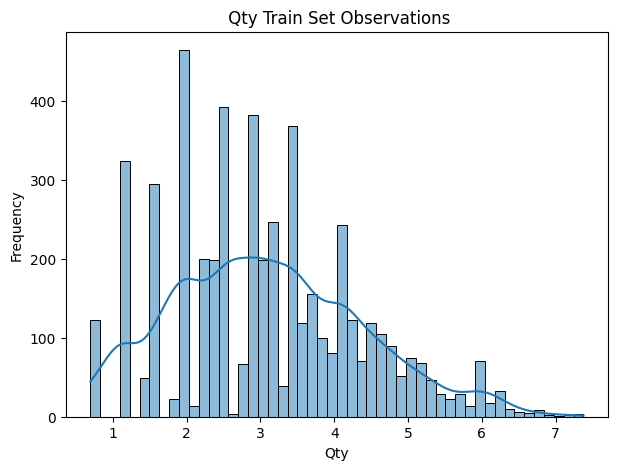

In [181]:
plt.figure(figsize=(7,5))
sns.histplot(y_val, bins=50, kde=True, edgecolor="black")
plt.title(" Qty Train Set Observations")
plt.xlabel("Qty")
plt.ylabel("Frequency")
plt.show()

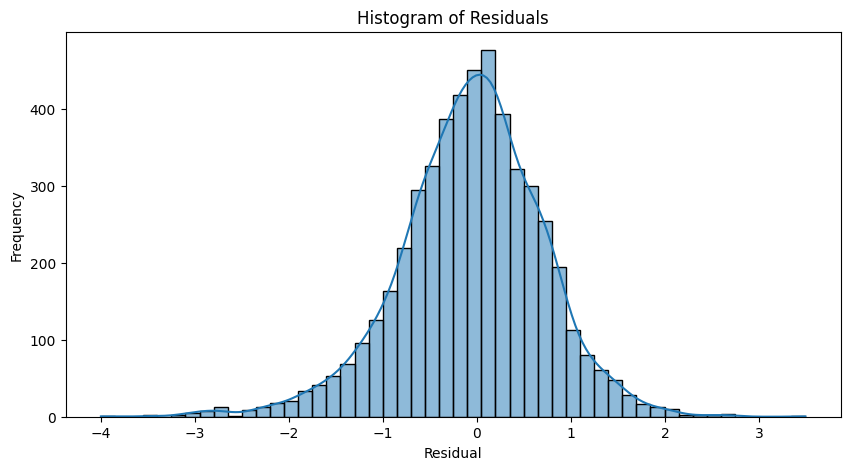

In [182]:
plt.figure(figsize=(10,5))
sns.histplot(resid_val, bins=50, kde=True, edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [72]:
test[target].describe()

count    3601.000000
mean        2.974505
std         1.371612
min         0.000000
25%         1.945910
50%         2.944439
75%         3.931826
max         7.230563
Name: qty_sold_log, dtype: float64

In [73]:
pd.Series(y_val_pred).describe()

count    3601.000000
mean        2.789705
std         0.962246
min         0.859725
25%         2.092241
50%         2.699928
75%         3.375713
max         6.401949
dtype: float64

In [74]:
pd.Series(resid_val).describe()

count    5077.000000
mean       -0.040611
std         0.762910
min        -3.914515
25%        -0.479270
50%        -0.019376
75%         0.438262
max         3.527452
Name: qty_sold_log, dtype: float64

In [464]:
# trainR2_residuals = resid_train
# valR2_residuals = resid_val
                
trainR2_residuals = resid_train
valR2_residuals = resid_val
# params = {
#     "learning_rate":0.001,
#     "max_depth": 8,
#     "num_leaves": 64
# }
# train_param = {
#     "X": X_train,
#     "y": trainR2_residuals,
# }

# eval_param = {
#     "X": X_val,
#     "y": valR2_residuals,
# }

model = train_model(train_param, eval_param, cat_feats, params)
pred_residuals = model.predict(X_val)
rmse = root_mean_squared_error(valR2_residuals, pred_residuals)
mae = mean_absolute_error(valR2_residuals, pred_residuals)
print(f"Residual ln(X_squared) RMSE: {rmse:.5f}")
print(f"Residual ln(X_squared) MAE: {mae:.5f}")
pred_residuals_unscaled = np.expm1(np.sqrt(pred_residuals))

rmse = root_mean_squared_error(resid_val, pred_residuals_unscaled)
mae = mean_absolute_error(resid_val, pred_residuals_unscaled)
print(f"Actual Residual RMSE: {rmse:.5f}")
print(f"Actual Residual MAE: {mae:.5f}")

NameError: name 'train_param' is not defined

In [183]:

predictions = pd.DataFrame({
    "client": test['cust_id'],
    "item": test['item'],
    "date": test['date'],
    "log(qty_sold)": y_actual,
    "log(qty_sold) prediction": y_val_pred,
    # "qty_sold inverse log": np.expm1(y_actual),
    "qty_sold inverse log prediction": np.expm1(y_val_pred ),
    "qty_sold actual": test['qty_sold']
    # "actual_resid": resid_val,
    # "resid_pred": pred_residuals,
    # "final_upper": y_val_pred + pred_residuals_unscaled, 
    # "final_lower": y_val_pred - pred_residuals_unscaled  
})
# predictions["within actual"] = y_val.between(predictions["final_lower"], predictions["final_upper"])
predictions.to_csv("predictions.csv", index=False)
predictions

client     item       date  log(qty_sold)  log(qty_sold) prediction  \
16317      OEM 1  4750823 2025-01-02       1.098612                  1.961424   
16316      OEM 1  4750814 2025-01-02       2.564949                  2.430641   
16304      OEM 1  4750831 2025-01-02       1.609438                  1.605912   
16307      OEM 1  4750822 2025-01-02       2.197225                  2.071791   
16305      OEM 1  4750819 2025-01-02       1.098612                  2.116669   
...          ...      ...        ...            ...                       ...   
21501  V004 - SO  4750980 2025-06-30       2.944439                  3.788804   
21482  D001 - AP  4750075 2025-06-30       5.379897                  4.712870   
21540  L001 - SA  4750172 2025-06-30       3.044522                  3.281223   
21481  D001 - AP  4750074 2025-06-30       5.323010                  4.765421   
21510  E001 - SA  4750258 2025-06-30       4.110874                  4.320678   

       qty_sold inverse log prediction  qty_sold actual  
16317                         6.109441                2  
16316                        10.366165               12  
16304                         3.982402                4  
16307                         6.939030                8  
16305                         7.303436                2  
...                                ...              ...  
21501                        43.203491               18  
21482                       110.371300              216  
21540                        25.608304               20  
21481                       116.380564              204  
21510                        74.239594               60  

[5077 rows x 7 columns]

In [ ]:
predictions["within actual"].value_counts()

In [266]:
df["series_id"] = df["cust_id"].astype(str) + "_" + df["item"].astype(str) + "_" + df["date"].astype(str)

In [278]:
predictions = pd.DataFrame({
    "client": train['cust_id'],
    "item": train['item'],
    "date": train['date'],
    "log(qty_sold)": y_train,
    "log(qty_sold) prediction": y_train_pred,
    "qty_sold inverse log": np.expm1(y_train),
    "qty_sold inverse log prediction": np.expm1(y_train_pred + 0.5 * np.var(resid_val, ddof=1)),
    "qty_sold actual": train['qty_sold']
    # "actual_resid": resid_val,
    # "resid_pred": pred_residuals,
    # "final_upper": y_val_pred + pred_residuals_unscaled, 
    # "final_lower": y_val_pred - pred_residuals_unscaled  
})
# predictions["within actual"] = y_val.between(predictions["final_lower"], predictions["final_upper"])
predictions.to_csv("predictions_train.csv", index=False)
predictions

client     item       date  log(qty_sold)  log(qty_sold) prediction  \
0      L001 - SA  4750828 2023-07-04       1.098612                  1.474712   
12     P001 - SA  4750418 2023-07-05       2.833213                  3.102228   
22     P001 - SA  4750415 2023-07-05       0.000000                  0.023668   
9      P001 - SA  4750415 2023-07-05       2.833213                  3.097472   
25     P001 - SA  4750418 2023-07-05       0.000000                  0.023528   
...          ...      ...        ...            ...                       ...   
17864  V001 - SO  4750106 2025-02-28       4.510860                  4.297916   
17947  V007 - SO  4750592 2025-02-28       1.098612                  1.417761   
17914  T001 - MA  4750877 2025-02-28       0.000000                  0.018230   
17958  V007 - SO  4750618 2025-02-28       3.761200                  4.030856   
17920  T001 - MA  4750890 2025-02-28       0.000000                  0.019097   

       qty_sold inverse log  qty_sold inverse log prediction  qty_sold actual  
0                       2.0                         4.929438                2  
12                     16.0                        29.188030               16  
22                      0.0                         0.389418                0  
9                      16.0                        29.044800               16  
25                      0.0                         0.389225                0  
...                     ...                              ...              ...  
17864                  90.0                        98.796515               90  
17947                   2.0                         4.601186                2  
17914                   0.0                         0.381883                0  
17958                  42.0                        75.406910               42  
17920                   0.0                         0.383083                0  

[17964 rows x 8 columns]

In [268]:
import pandas as pd
from sklearn.ensemble import IsolationForest

data = df["qty_sold"]

X = data.to_frame(name="qty_sold")
# Fit Isolation Forest
clf = IsolationForest(contamination=0.15, random_state=42)  # contamination = expected % outliers
clf.fit(X)

# Predict
outlier_s = clf.predict(X)  # -1 = outlier, 1 = normal
s_scores = clf.decision_function(X)  # anomaly score

outliers = pd.DataFrame({
    "series_id": df["series_id"],
    "qty_sold": data,
    "outlier_flag": outlier_s,
    "score": s_scores
})
outliers.to_csv("outliers.csv")

### FIXING RESIDUALS

In [507]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assume y_true and y_pred_base are numpy arrays
residuals = resid_val.values

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_res, y_res = create_sequences(residuals, seq_length)

# Convert to PyTorch tensors
X_res = torch.from_numpy(X_res).float().unsqueeze(-1)  # [samples, seq_len, 1]
y_res = torch.from_numpy(y_res).float().unsqueeze(-1)

# Create DataLoader
dataset = TensorDataset(X_res, y_res)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [508]:
class ResidualLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)  # out: [batch, seq_len, hidden]
        out = out[:, -1, :]    # take last time step
        out = self.fc(out)
        return out

model = ResidualLSTM()


In [509]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 10, Loss: 0.021778
Epoch 20, Loss: 0.229623
Epoch 30, Loss: 1.158320
Epoch 40, Loss: 0.347594
Epoch 50, Loss: 0.868525


In [481]:
print(len(resid_val))
print(seq_length)


5263
10


In [510]:
# Prepare test sequences (same seq_length)
X_test_res, _ = create_sequences(resid_val.values, seq_length)
X_test_res = torch.from_numpy(X_test_res).float().unsqueeze(-1)

model.eval()
with torch.no_grad():
    residuals_pred = model(X_test_res).numpy()

# Final hybrid prediction
y_pred_final = y_pred[seq_length:] + residuals_pred.squeeze()
rmse = root_mean_squared_error(y_actual[seq_length:], y_pred_final)
mae = mean_absolute_error(y_actual[seq_length:], y_pred_final)
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")

RMSE: 0.75674
MAE: 0.56787


In [515]:
pd.Series(residuals_pred.squeeze()).describe()

count    5253.000000
mean       -0.029224
std         0.121267
min        -0.953385
25%        -0.078859
50%        -0.010419
75%         0.042022
max         0.502463
dtype: float64

In [512]:
resid_val[seq_length:].values

array([-0.09298042,  0.25284481,  0.24873331, ..., -0.76008392,
        0.47662502, -0.03691443], shape=(5253,))

In [513]:
res = pd.DataFrame({
    "res_pred": residuals_pred.squeeze(),  
    "res_actual": resid_val[seq_length:].values
})
res

res_pred  res_actual
0    -0.114688   -0.092980
1    -0.030074    0.252845
2     0.012407    0.248733
3    -0.037322   -0.551617
4    -0.169443   -1.073137
...        ...         ...
5248 -0.161197    0.886656
5249 -0.072741   -0.677537
5250 -0.070460   -0.760084
5251 -0.242484    0.476625
5252  0.008820   -0.036914

[5253 rows x 2 columns]

In [488]:
resid_val

16309   -0.158618
16312   -0.502278
16308   -0.359635
16303    0.894105
16310   -0.890138
           ...   
21492    0.886656
21498   -0.677537
21499   -0.760084
21493    0.476625
21487   -0.036914
Name: qty_sold_log, Length: 5263, dtype: float64